In [1]:
import numpy as np
import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(20092024)

In [2]:
dataset_df = pd.read_csv("diabetes.csv")
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.insert(0, 'Outcome', dataset_df.pop('Outcome'))

print(dataset_df.head())
print(dataset_df.describe())

   Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0        1            6      148             72             35        0  33.6   
1        0            1       85             66             29        0  26.6   
2        1            8      183             64              0        0  23.3   
3        0            1       89             66             23       94  28.1   
4        1            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  
          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  120.894531      69.105469      20.536458   
std      0.476951     3.369578   31.972618      19.355807      15.952218   

In [3]:
# Fix missing or zero values
fix_missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness',
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

dataset_df[fix_missing_cols] = dataset_df[fix_missing_cols].replace(0, np.nan)
for col in fix_missing_cols:
    dataset_df[col] = dataset_df[col].fillna(dataset_df[col].mean())

print(dataset_df.describe())

          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  121.686763      72.405184      29.153420   
std      0.476951     3.369578   30.435949      12.096346       8.790942   
min      0.000000     0.000000   44.000000      24.000000       7.000000   
25%      0.000000     1.000000   99.750000      64.000000      25.000000   
50%      0.000000     3.000000  117.000000      72.202592      29.153420   
75%      1.000000     6.000000  140.250000      80.000000      32.000000   
max      1.000000    17.000000  199.000000     122.000000      99.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  768.000000  768.000000                768.000000  768.000000  
mean   155.548223   32.457464                  0.471876   33.240885  
std     85.021108    6.875151                  0.331329   11.760232  
min     14.000000   18.200000      

In [4]:
scaled_dataset_df = dataset_df.copy()

# standardize
for col in scaled_dataset_df.columns:
    if col == 'Outcome':
        continue
    scaled_dataset_df[col] = (
        scaled_dataset_df[col] - scaled_dataset_df[col].mean()) / scaled_dataset_df[col].std()

print(scaled_dataset_df.describe())

          Outcome   Pregnancies       Glucose  BloodPressure  SkinThickness  \
count  768.000000  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02   
mean     0.348958 -7.864080e-17 -3.492577e-16   6.869505e-16   7.956598e-16   
std      0.476951  1.000000e+00  1.000000e+00   1.000000e+00   1.000000e+00   
min      0.000000 -1.141108e+00 -2.552467e+00  -4.001637e+00  -2.520028e+00   
25%      0.000000 -8.443348e-01 -7.207517e-01  -6.948531e-01  -4.724658e-01   
50%      0.000000 -2.507887e-01 -1.539877e-01  -1.674821e-02   8.082669e-16   
75%      1.000000  6.395305e-01  6.099116e-01   6.278603e-01   3.238084e-01   
max      1.000000  3.904034e+00  2.540195e+00   4.099983e+00   7.945290e+00   

            Insulin           BMI  DiabetesPedigreeFunction           Age  
count  7.680000e+02  7.680000e+02              7.680000e+02  7.680000e+02  
mean  -3.238150e-16  3.561966e-16              2.451743e-16  2.035409e-16  
std    1.000000e+00  1.000000e+00              1.000000e+00 

In [5]:
# https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4

from pandas import DataFrame


class DiabetesDataset(Dataset):
    def __init__(self, df: DataFrame):
        self.tensor = torch.tensor(df.to_numpy(dtype=np.float32))

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        row = self.tensor[idx]
        return row[1:], row[0]

In [6]:
print(scaled_dataset_df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20092024)

# train_idx, test_idx = next(sss.split(scaled_dataset_df.iloc[:, 1:], scaled_dataset_df['Outcome']))

# train_df = scaled_dataset_df.iloc[train_idx]
# test_df = scaled_dataset_df.iloc[test_idx]

# train_dataset = DiabetesDataset(train_df)
# test_dataset = DiabetesDataset(test_df)

# print(train_df['Outcome'].value_counts())
# print(test_df['Outcome'].value_counts())

In [8]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=8, random_state=20092024, shuffle=True)

folds = []

for i, (train_idx, test_idx) in enumerate(skf.split(scaled_dataset_df.iloc[:, 1:], scaled_dataset_df['Outcome'])):
    train_i_df = scaled_dataset_df.iloc[train_idx]
    test_i_df = scaled_dataset_df.iloc[test_idx]

    train_i_dataset = DiabetesDataset(train_i_df)
    test_i_dataset = DiabetesDataset(test_i_df)

    folds.append((train_i_dataset, test_i_dataset))

    print(f"Fold {i}")
    counts = train_i_df['Outcome'].value_counts()
    print(f"Train split: {counts[0]}, {counts[1]}")
    counts = test_i_df['Outcome'].value_counts()
    print(f"Test split: {counts[0]}, {counts[1]}")

Fold 0
Train split: 438, 234
Test split: 62, 34
Fold 1
Train split: 438, 234
Test split: 62, 34
Fold 2
Train split: 438, 234
Test split: 62, 34
Fold 3
Train split: 438, 234
Test split: 62, 34
Fold 4
Train split: 437, 235
Test split: 63, 33
Fold 5
Train split: 437, 235
Test split: 63, 33
Fold 6
Train split: 437, 235
Test split: 63, 33
Fold 7
Train split: 437, 235
Test split: 63, 33


In [9]:
def test(dataset, predict_fn, negative_label=0, positive_label=1):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for xi, yi in dataset:
        yi_pred = predict_fn(xi)
        if yi == negative_label:
            if yi_pred == negative_label:
                tn += 1
            else:
                fp += 1
        else:
            if yi_pred == positive_label:
                tp += 1
            else:
                fn += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * (precision * recall) / (precision +
                                     recall) if (precision + recall) else 0

    mccd = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    if mccd == 0:
        mcc = 0
    else:
        mcc = (tp * tn - fp * fn) / mccd

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fp_rate': fp / (fp + tn) if (fp + tn) else 0,
        'tp_rate': tp / (tp + fn) if (tp + fn) else 0,
        'mcc': mcc
    }

In [75]:
class BasePerceptronNeg():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        sm = torch.zeros(len(self.weights))
        # print(self.weights)
        for xi, yi in dataset:
            # print(f"xi {xi}")
            # print(f"yi {yi}")

            cond = yi * torch.dot(xi, self.weights)
            indicate = 1 if cond <= 0 else 0
            # print(torch.dot(xi, self.weights))
            # print(f"condition {cond}")
            # print(f"indicate {indicate}")
            adjust = yi * xi
            # print(f"adjust {adjust}")

            sm += adjust * indicate

        # print(f"sum {sm}")
        self.weights = self.weights + learning_rate * sm
        # print(self.weights)

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) > 0 else -1


class BasePerceptronWrongButOk():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        sm = torch.zeros(len(self.weights))
        # print(self.weights)
        for xi, yi in dataset:
            # print(f"xi {xi}")
            # print(f"yi {yi}")

            cond = yi * torch.dot(xi, self.weights)
            indicate = 1 if (yi == 1 and cond < 0.5) or (
                yi == 0 and cond >= 0.5) else 0

            # print(torch.dot(xi, self.weights))
            # print(f"condition {cond}")
            # print(f"indicate {indicate}")
            adjust = yi * xi
            # print(f"adjust {adjust}")

            sm += adjust * indicate

        # print(f"sum {sm}")
        self.weights = self.weights + learning_rate * sm
        # print(self.weights)

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0.5 else 0


class BasePerceptron():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                self.weights += learning_rate * y_mapped * xi

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


class PerceptronWithBiasV3():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size + 1)

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            xi = torch.cat((xi, torch.tensor([1.0])))
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                self.weights += learning_rate * y_mapped * xi

    def predict_prob(self, new_X: torch.Tensor):
        new_X = torch.cat((new_X, torch.tensor([1.0])))
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


class PerceptronWithBiasV3WithReg():
    weights: torch.Tensor

    def __init__(self, size: int, l2_lambda=0.01, class_weights=(1, 1)):
        self.weights = torch.zeros(size + 1)
        self.l2_lambda = l2_lambda
        self.class_weights = class_weights

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            xi = torch.cat((xi, torch.tensor([1.0])))
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                regularization_term = self.l2_lambda * self.weights
                regularization_term[-1] = 0

                class_weight = self.class_weights[int(yi)]

                self.weights += learning_rate * y_mapped * xi * class_weight - regularization_term

    def predict_prob(self, new_X: torch.Tensor):
        new_X = torch.cat((new_X, torch.tensor([1.0])))
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


# class PerceptronWithBiasV2():
#     weights: torch.Tensor

#     def __init__(self, size: int):
#         self.weights = torch.zeros(size + 1)

#     def update(self, learning_rate: float, dataset: Dataset):
#         sm = torch.zeros(len(self.weights))

#         for xi, yi in dataset:
#             xi = torch.cat((xi, torch.tensor([1.0])))

#             prob = torch.dot(xi, self.weights)

#             pred = 1 if prob >= 0.5 else 0

#             indicate = yi - pred

#             sm += indicate * xi

#         self.weights = self.weights + learning_rate * sm

#     def predict_prob(self, new_X: torch.Tensor):
#         new_X = torch.cat((new_X, torch.tensor([1.0])))
#         return torch.dot(new_X, self.weights)

#     def predict(self, new_X: torch.Tensor):
#         return 1 if self.predict_prob(new_X) >= 0.5 else 0


# class PerceptronWithBias():
#     weights: torch.Tensor

#     def __init__(self, size: int):
#         self.weights = torch.zeros(size + 1)

#     def update(self, learning_rate: float, dataset: Dataset):
#         sm = torch.zeros(len(self.weights))
#         # print(self.weights)

#         for xi, yi in dataset:

#             xi = torch.cat((xi, torch.tensor([1.0])))
#             # print(f"xi {xi}")
#             # print(f"yi {yi}")

#             cond = yi * torch.dot(xi, self.weights)
#             indicate = 1 if (yi == 1 and cond < 0.5) or (
#                 yi == 0 and cond >= 0.5) else 0
#             # print(torch.dot(xi, self.weights))
#             # print(f"condition {cond}")
#             # print(f"indicate {indicate}")
#             adjust = yi * xi
#             # print(f"adjust {adjust}")

#             sm += adjust * indicate

#         # print(f"sum {sm}")
#         self.weights = self.weights + learning_rate * sm
#         # print(self.weights)

#     def predict_prob(self, new_X: torch.Tensor):
#         new_X = torch.cat((new_X, torch.tensor([1.0])))
#         return torch.dot(new_X, self.weights)

#     def predict(self, new_X: torch.Tensor):
#         return 1 if self.predict_prob(new_X) >= 0.5 else 0


# class PerceptronWithBiasAndReg:
#     weights: torch.Tensor

#     def __init__(self, size: int, l2_lambda=0.01):
#         self.weights = torch.zeros(size + 1)
#         self.l2_lambda = l2_lambda

#     def update(self, learning_rate: float, dataset: Dataset):
#         sm = torch.zeros(len(self.weights))

#         for xi, yi in dataset:
#             xi = torch.cat((xi, torch.tensor([1.0])))

#             prob = torch.dot(xi, self.weights)

#             pred = 1 if prob >= 0.5 else 0

#             indicate = yi - pred

#             sm += indicate * xi

#         regularization_term = self.l2_lambda * self.weights
#         regularization_term[-1] = 0

#         self.weights = self.weights + learning_rate * sm - regularization_term

#     def predict_prob(self, new_X: torch.Tensor):
#         new_X = torch.cat((new_X, torch.tensor([1.0])))
#         return torch.dot(new_X, self.weights)

#     def predict(self, new_X: torch.Tensor):
#         return 1 if self.predict_prob(new_X) >= 0.5 else 0


class BasePerceptronGPU():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.ones(size).to('cuda')
        print(self.weights.shape)

    def update(self, learning_rate: float, dataset: Dataset):
        X, Y = zip(*[(xi, yi) for xi, yi in dataset])
        X = torch.stack(X).to('cuda')  # Shape: [N, size]
        Y = torch.tensor(Y, device='cuda', dtype=torch.float32)  # Shape: [N]

        # Compute the condition and the indicator more efficiently
        indicate = (Y * torch.matmul(X, self.weights)) < 0  # Shape: [N]

        # Using boolean indexing to directly calculate the sum of adjustments
        sm = torch.sum(X[indicate] * Y[indicate].unsqueeze(1), dim=0)

        # Update weights using the computed sum with broadcasting
        self.weights += learning_rate * sm

    def predict(self, new_X: torch.Tensor):
        new_X = new_X.to('cuda')
        return 1 if torch.dot(new_X, self.weights) > 0 else 0

In [11]:
def plot_evals_individual(test_evals, train_evals):
    plt.title('Accuracy')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['accuracy'],
             label='Test Accuracy')
    plt.plot(train_evals['epoch'],
             train_evals['accuracy'], label='Train Accuracy')
    plt.legend()
    plt.show()

    plt.title('Precision')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['precision'],
             label='Test Precision')
    plt.plot(train_evals['epoch'],
             train_evals['precision'], label='Train Precision')
    plt.legend()
    plt.show()

    plt.title('Recall')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['recall'], label='Test Recall')
    plt.plot(train_evals['epoch'], train_evals['recall'], label='Train Recall')
    plt.legend()
    plt.show()

    plt.title('F1')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['f1'], label='Test F1')
    plt.plot(train_evals['epoch'], train_evals['f1'], label='Train F1')
    plt.legend()
    plt.show()

    plt.title('MCC')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['mcc'], label='Test MCC')
    plt.plot(train_evals['epoch'], train_evals['mcc'], label='Train MCC')
    plt.legend()
    plt.show()

In [12]:
def plot_evals_subplot(test_evals, train_evals):
    fig, axs = plt.subplots(3, 2)
    fig.suptitle('Metrics')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].plot(test_evals['epoch'], test_evals['accuracy'],
                   label='Test Accuracy')
    axs[0, 0].plot(train_evals['epoch'],
                   train_evals['accuracy'], label='Train Accuracy')
    axs[0, 0].legend()
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].plot(test_evals['epoch'], test_evals['precision'],
                   label='Test Precision')
    axs[0, 1].plot(train_evals['epoch'],
                   train_evals['precision'], label='Train Precision')
    axs[0, 1].legend()
    axs[0, 1].set_title('Precision')

    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].plot(test_evals['epoch'],
                   test_evals['recall'], label='Test Recall')
    axs[1, 0].plot(train_evals['epoch'],
                   train_evals['recall'], label='Train Recall')
    axs[1, 0].legend()
    axs[1, 0].set_title('Recall')

    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].plot(test_evals['epoch'], test_evals['f1'], label='Test F1')
    axs[1, 1].plot(train_evals['epoch'], train_evals['f1'], label='Train F1')
    axs[1, 1].legend()
    axs[1, 1].set_title('F1')

    axs[2, 0].set_ylim(0, 1)
    axs[2, 0].plot(test_evals['epoch'], test_evals['mcc'], label='Test MCC')
    axs[2, 0].plot(train_evals['epoch'], train_evals['mcc'], label='Train MCC')
    axs[2, 0].legend()
    axs[2, 0].set_title('MCC')

    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.show()

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_pr_curve(fold_test_sets, fold_models):
    """
    Draw a Cross Validated PR Curve.
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    all_y_real = []
    all_y_probs = []
    for i, (test_dataset, model) in enumerate(zip(fold_test_sets, fold_models)):
        X, y = zip(*[(xi, yi.item()) for xi, yi in test_dataset])

        probs = [model.predict_prob(xi) for xi in X]

        precision, recall, _ = precision_recall_curve(y, probs)

        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y, probs)))

        all_y_real.append(y)
        all_y_probs.append(probs)

    all_y_real = np.concatenate(all_y_real)
    all_y_probs = np.concatenate(all_y_probs)

    all_precision, all_recall, _ = precision_recall_curve(
        all_y_real, all_y_probs)

    plt.plot(all_recall, all_precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (
                 average_precision_score(all_y_real, all_y_probs)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
def table_metrics(fold_evals):
    final_metrics = []
    for (test_evals, _) in fold_evals:
        final_metrics.append(test_evals.iloc[-1])

    print(pd.DataFrame(final_metrics).describe())
    return pd.DataFrame(final_metrics)

In [15]:
eval_dtypes = {
    'epoch': 'int64',
    'accuracy': 'float64',
    'precision': 'float64',
    'recall': 'float64',
    'f1': 'float64',
    'fp_rate': 'float64',
    'tp_rate': 'float64',
    'mcc': 'float64'
}


def train_model(model, train_dataset, test_dataset, t=0, epochs=100, lr=0.01, test_period=10, negative_label=0):
    test_evals = pd.DataFrame({col: pd.Series(dtype=dtype)
                              for col, dtype in eval_dtypes.items()})
    train_evals = pd.DataFrame({col: pd.Series(dtype=dtype)
                               for col, dtype in eval_dtypes.items()})

    test_eval = test(test_dataset, model.predict,
                     negative_label=negative_label)
    train_eval = test(train_dataset, model.predict,
                      negative_label=negative_label)
    test_eval['epoch'] = t
    train_eval['epoch'] = t
    test_evals = pd.concat([test_evals, pd.DataFrame([test_eval])])
    train_evals = pd.concat([train_evals, pd.DataFrame([train_eval])])

    for _ in range(epochs):
        model.update(lr, train_dataset)
        t += 1
        if t % test_period == 0:
            test_eval = test(test_dataset, model.predict,
                             negative_label=negative_label)
            train_eval = test(train_dataset, model.predict,
                              negative_label=negative_label)
            test_eval['epoch'] = t
            train_eval['epoch'] = t
            test_evals = pd.concat([test_evals, pd.DataFrame([test_eval])])
            train_evals = pd.concat([train_evals, pd.DataFrame([train_eval])])
            print(f"t={t} Test Acc: {test_eval['accuracy']:0.3f} Train Acc: {
                  train_eval['accuracy']:0.3f}")

    return test_evals, train_evals

In [22]:
lr = 0.01
epochs = 300
v1_fold_evals = []
v1_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = BasePerceptron(train_i_df.shape[1] - 1)
    t = 0

    test_evals, train_evals = train_model(
        model, train_dataset, test_dataset, t, epochs, lr, 10)

    v1_fold_evals.append((test_evals, train_evals))
    v1_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.771 Train Acc: 0.704
t=20 Test Acc: 0.729 Train Acc: 0.676
t=30 Test Acc: 0.656 Train Acc: 0.643
t=40 Test Acc: 0.708 Train Acc: 0.713
t=50 Test Acc: 0.729 Train Acc: 0.725
t=60 Test Acc: 0.740 Train Acc: 0.702
t=70 Test Acc: 0.688 Train Acc: 0.714
t=80 Test Acc: 0.667 Train Acc: 0.726
t=90 Test Acc: 0.719 Train Acc: 0.662
t=100 Test Acc: 0.708 Train Acc: 0.659
t=110 Test Acc: 0.594 Train Acc: 0.683
t=120 Test Acc: 0.729 Train Acc: 0.668
t=130 Test Acc: 0.667 Train Acc: 0.722
t=140 Test Acc: 0.708 Train Acc: 0.734
t=150 Test Acc: 0.708 Train Acc: 0.686
t=160 Test Acc: 0.750 Train Acc: 0.698
t=170 Test Acc: 0.740 Train Acc: 0.710
t=180 Test Acc: 0.719 Train Acc: 0.714
t=190 Test Acc: 0.677 Train Acc: 0.698
t=200 Test Acc: 0.646 Train Acc: 0.616
t=210 Test Acc: 0.729 Train Acc: 0.683
t=220 Test Acc: 0.667 Train Acc: 0.689
t=230 Test Acc: 0.708 Train Acc: 0.673
t=240 Test Acc: 0.740 Train Acc: 0.665
t=250 Test Acc: 0.625 Train Acc: 0.619
t=260 Test Acc: 0.708 Train

       epoch  accuracy  precision    recall        f1   fp_rate   tp_rate  \
count    8.0  8.000000   8.000000  8.000000  8.000000  8.000000  8.000000   
mean   300.0  0.704427   0.562813  0.704991  0.623876  0.295635  0.704991   
std      0.0  0.058380   0.074846  0.103449  0.077152  0.064841  0.103449   
min    300.0  0.604167   0.439024  0.545455  0.486486  0.209677  0.545455   
25%    300.0  0.661458   0.504148  0.651292  0.596230  0.250000  0.651292   
50%    300.0  0.729167   0.593237  0.720588  0.653058  0.296083  0.720588   
75%    300.0  0.744792   0.612722  0.770499  0.669014  0.329365  0.770499   
max    300.0  0.760417   0.648649  0.848485  0.708861  0.396825  0.848485   

            mcc  
count  8.000000  
mean   0.395162  
std    0.124009  
min    0.173193  
25%    0.341595  
50%    0.441021  
75%    0.467961  
max    0.535050  


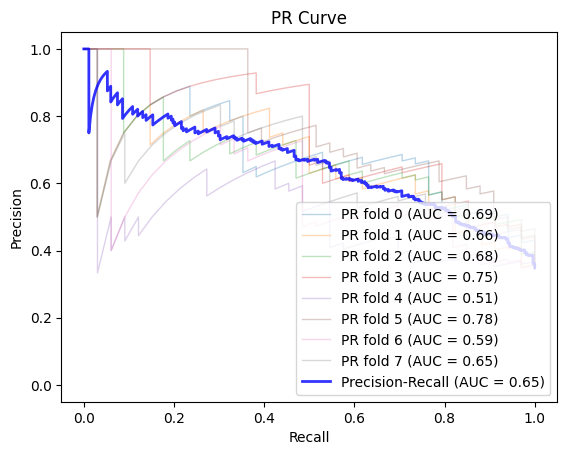

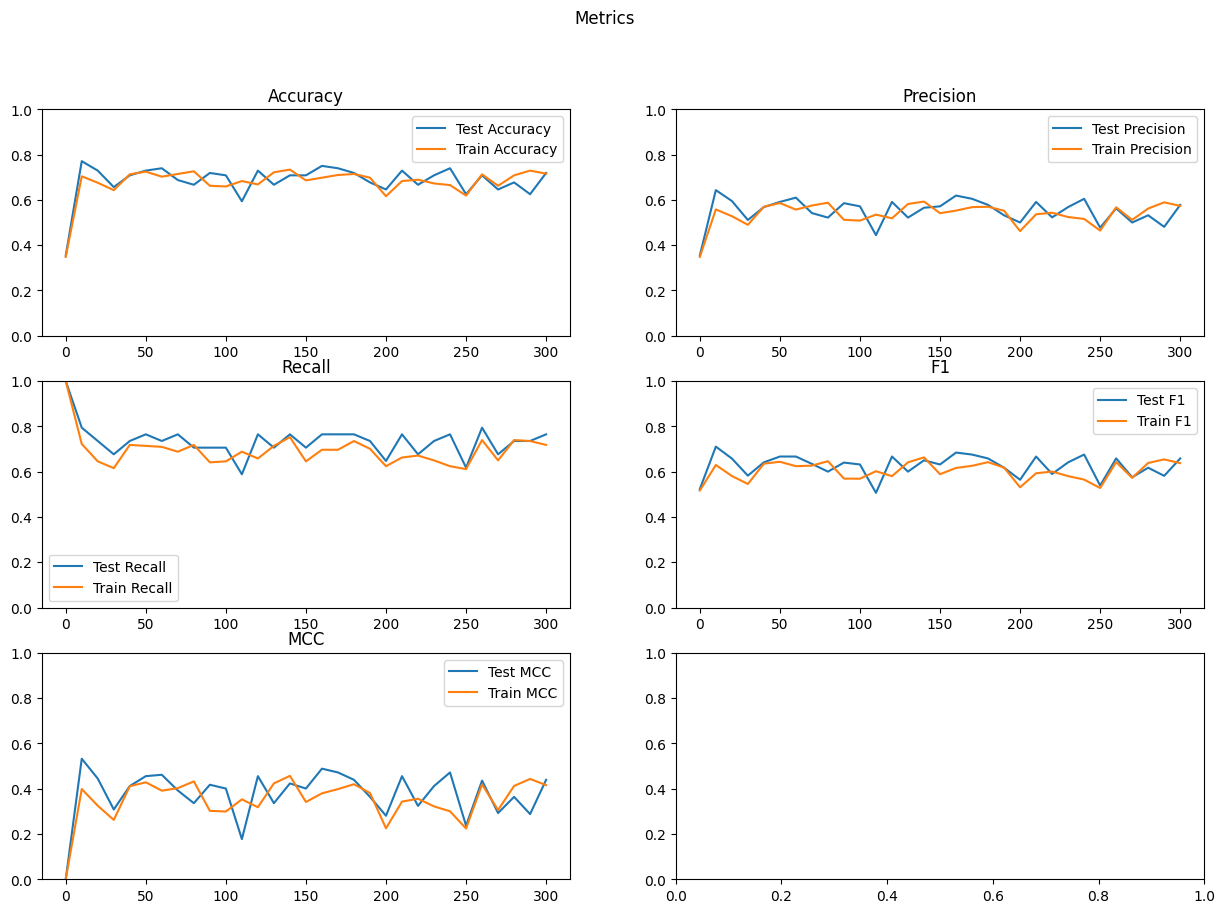

In [23]:
table_metrics(v1_fold_evals)
plot_pr_curve([test_dataset for train_dataset,
              test_dataset in folds], v1_fold_models)
plot_evals_subplot(v1_fold_evals[0][0], v1_fold_evals[0][1])

In [24]:
lr = 0.01
epochs = 200
with_bias_fold_evals = []
with_bias_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = PerceptronWithBiasV3(len(train_dataset[0][0]))
    t = 0

    test_evals, train_evals = train_model(
        model, train_dataset, test_dataset, t, epochs, lr, 10)

    with_bias_fold_evals.append((test_evals, train_evals))
    with_bias_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.698 Train Acc: 0.707
t=20 Test Acc: 0.760 Train Acc: 0.759
t=30 Test Acc: 0.698 Train Acc: 0.683
t=40 Test Acc: 0.656 Train Acc: 0.704
t=50 Test Acc: 0.719 Train Acc: 0.713
t=60 Test Acc: 0.740 Train Acc: 0.716
t=70 Test Acc: 0.781 Train Acc: 0.735
t=80 Test Acc: 0.729 Train Acc: 0.738
t=90 Test Acc: 0.656 Train Acc: 0.726
t=100 Test Acc: 0.708 Train Acc: 0.726
t=110 Test Acc: 0.698 Train Acc: 0.743
t=120 Test Acc: 0.667 Train Acc: 0.680
t=130 Test Acc: 0.667 Train Acc: 0.710
t=140 Test Acc: 0.656 Train Acc: 0.699
t=150 Test Acc: 0.688 Train Acc: 0.702
t=160 Test Acc: 0.729 Train Acc: 0.699
t=170 Test Acc: 0.729 Train Acc: 0.716
t=180 Test Acc: 0.760 Train Acc: 0.726
t=190 Test Acc: 0.656 Train Acc: 0.662
t=200 Test Acc: 0.729 Train Acc: 0.722
Fold 1
t=10 Test Acc: 0.594 Train Acc: 0.699
t=20 Test Acc: 0.615 Train Acc: 0.682
t=30 Test Acc: 0.625 Train Acc: 0.716
t=40 Test Acc: 0.615 Train Acc: 0.613
t=50 Test Acc: 0.615 Train Acc: 0.711
t=60 Test Acc: 0.708 Trai

       epoch  accuracy  precision    recall        f1   fp_rate   tp_rate  \
count    8.0  8.000000   8.000000  8.000000  8.000000  8.000000  8.000000   
mean   200.0  0.704427   0.589822  0.548574  0.564860  0.212078  0.548574   
std      0.0  0.072370   0.109665  0.100008  0.092018  0.082719  0.100008   
min    200.0  0.552083   0.384615  0.424242  0.410959  0.096774  0.424242   
25%    200.0  0.692708   0.565134  0.473930  0.512903  0.176715  0.473930   
50%    200.0  0.729167   0.608586  0.544118  0.601276  0.198413  0.544118   
75%    200.0  0.744792   0.648157  0.616310  0.618681  0.228879  0.616310   
max    200.0  0.770833   0.739130  0.696970  0.676471  0.387097  0.696970   

            mcc  
count  8.000000  
mean   0.345078  
std    0.150277  
min    0.052662  
25%    0.293941  
50%    0.407931  
75%    0.428095  
max    0.499807  


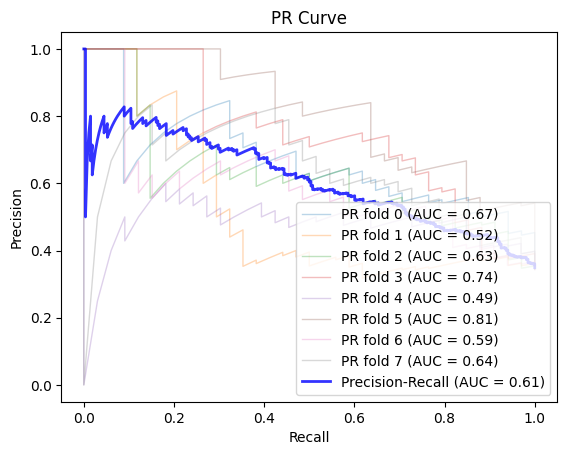

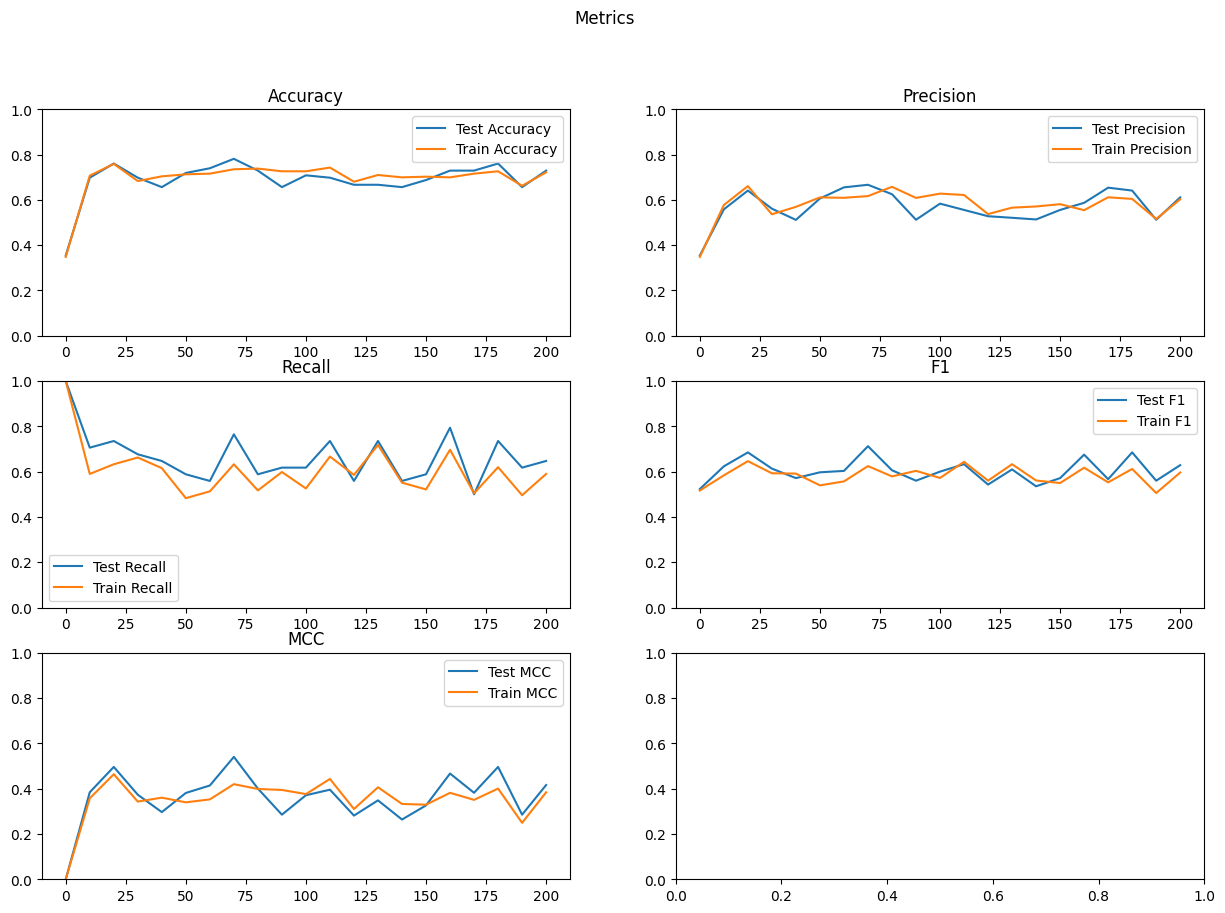

In [25]:
table_metrics(with_bias_fold_evals)
plot_pr_curve([test_dataset for train_dataset,
              test_dataset in folds], with_bias_fold_models)
plot_evals_subplot(with_bias_fold_evals[0][0], with_bias_fold_evals[0][1])

In [37]:
lr = 0.01
epochs = 200
with_bias_and_reg_fold_evals = []
with_bias_and_reg_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = PerceptronWithBiasV3WithReg(len(train_dataset[0][0]), 0.02)
    t = 0

    test_evals, train_evals = train_model(
        model, train_dataset, test_dataset, t, epochs, lr, 10)

    with_bias_and_reg_fold_evals.append((test_evals, train_evals))
    with_bias_and_reg_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.698 Train Acc: 0.683
t=20 Test Acc: 0.698 Train Acc: 0.720
t=30 Test Acc: 0.615 Train Acc: 0.676
t=40 Test Acc: 0.688 Train Acc: 0.698
t=50 Test Acc: 0.740 Train Acc: 0.763
t=60 Test Acc: 0.688 Train Acc: 0.723
t=70 Test Acc: 0.688 Train Acc: 0.647
t=80 Test Acc: 0.688 Train Acc: 0.698
t=90 Test Acc: 0.740 Train Acc: 0.763
t=100 Test Acc: 0.688 Train Acc: 0.723
t=110 Test Acc: 0.688 Train Acc: 0.647
t=120 Test Acc: 0.688 Train Acc: 0.698
t=130 Test Acc: 0.740 Train Acc: 0.763
t=140 Test Acc: 0.688 Train Acc: 0.723
t=150 Test Acc: 0.688 Train Acc: 0.647
t=160 Test Acc: 0.688 Train Acc: 0.698
t=170 Test Acc: 0.740 Train Acc: 0.763
t=180 Test Acc: 0.688 Train Acc: 0.723
t=190 Test Acc: 0.688 Train Acc: 0.647
t=200 Test Acc: 0.688 Train Acc: 0.698
Fold 1
t=10 Test Acc: 0.635 Train Acc: 0.679
t=20 Test Acc: 0.594 Train Acc: 0.690
t=30 Test Acc: 0.698 Train Acc: 0.713
t=40 Test Acc: 0.760 Train Acc: 0.734
t=50 Test Acc: 0.708 Train Acc: 0.722
t=60 Test Acc: 0.698 Trai

       epoch  accuracy  precision    recall        f1   fp_rate   tp_rate  \
count    8.0  8.000000   8.000000  8.000000  8.000000  8.000000  8.000000   
mean   200.0  0.695312   0.568922  0.530749  0.541079  0.215822  0.530749   
std      0.0  0.053623   0.093006  0.153210  0.107655  0.066309  0.153210   
min    200.0  0.614583   0.433333  0.294118  0.370370  0.096774  0.294118   
25%    200.0  0.653646   0.512097  0.451426  0.472405  0.171275  0.451426   
50%    200.0  0.703125   0.562030  0.507576  0.570355  0.232079  0.507576   
75%    200.0  0.729167   0.613252  0.645053  0.607368  0.270929  0.645053   
max    200.0  0.760417   0.739130  0.727273  0.676056  0.285714  0.727273   

            mcc  
count  8.000000  
mean   0.321787  
std    0.136217  
min    0.127163  
25%    0.214508  
50%    0.345872  
75%    0.430023  
max    0.490519  


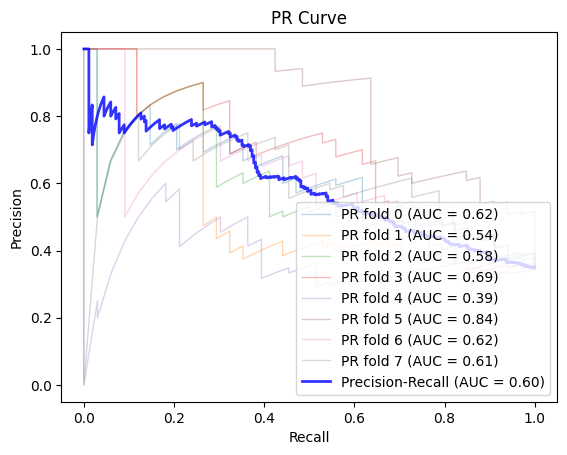

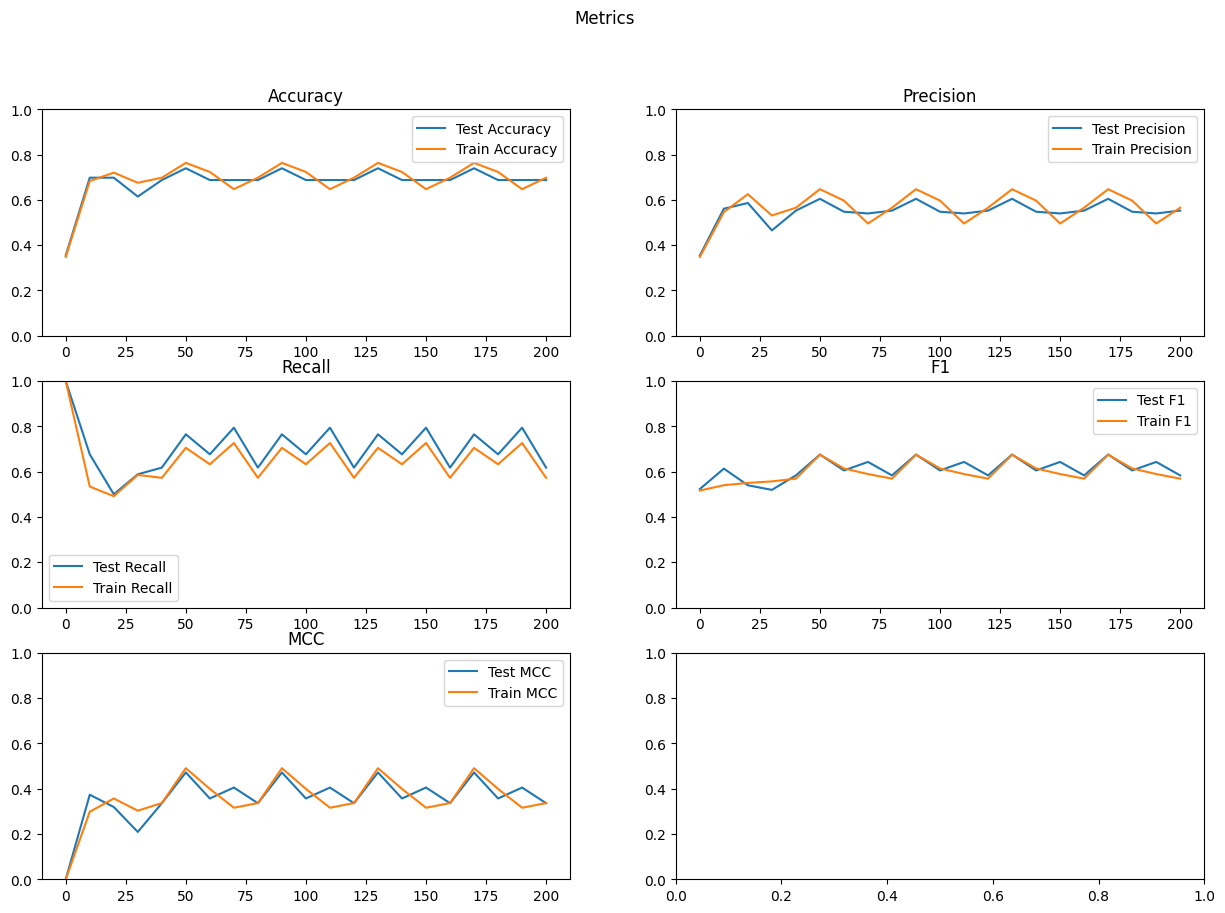

In [38]:
table_metrics(with_bias_and_reg_fold_evals)
plot_pr_curve([test_dataset for train_dataset,
              test_dataset in folds], with_bias_and_reg_fold_models)
plot_evals_subplot(
    with_bias_and_reg_fold_evals[0][0], with_bias_and_reg_fold_evals[0][1])

In [86]:
def calc_class_weights(dataset):
    class_counts = [0, 0]
    for xi, yi in dataset:
        class_counts[int(yi)] += 1

    class_weight_0 = len(dataset) / (class_counts[0] * 2)
    class_weight_1 = len(dataset) / (class_counts[1] * 2)
    print(f"Class weights: {class_weight_0}, {class_weight_1}") 

    return class_weight_0, class_weight_1

lr = 0.01
epochs = 200
class_weights_fold_evals = []
class_weights_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)   
    model = PerceptronWithBiasV3WithReg(len(train_dataset[0][0]), 0.00, class_weights=class_weights)
    t = 0

    test_evals, train_evals = train_model(
        model, train_dataset, test_dataset, t, epochs, lr, 10)

    class_weights_fold_evals.append((test_evals, train_evals))
    class_weights_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.583 Train Acc: 0.661
t=20 Test Acc: 0.792 Train Acc: 0.720
t=30 Test Acc: 0.708 Train Acc: 0.665
t=40 Test Acc: 0.719 Train Acc: 0.743
t=50 Test Acc: 0.635 Train Acc: 0.612
t=60 Test Acc: 0.708 Train Acc: 0.704
t=70 Test Acc: 0.740 Train Acc: 0.668
t=80 Test Acc: 0.646 Train Acc: 0.717
t=90 Test Acc: 0.708 Train Acc: 0.707
t=100 Test Acc: 0.698 Train Acc: 0.655
t=110 Test Acc: 0.729 Train Acc: 0.720
t=120 Test Acc: 0.750 Train Acc: 0.747
t=130 Test Acc: 0.719 Train Acc: 0.702
t=140 Test Acc: 0.677 Train Acc: 0.652
t=150 Test Acc: 0.656 Train Acc: 0.711
t=160 Test Acc: 0.802 Train Acc: 0.713
t=170 Test Acc: 0.698 Train Acc: 0.704
t=180 Test Acc: 0.688 Train Acc: 0.688
t=190 Test Acc: 0.635 Train Acc: 0.671
t=200 Test Acc: 0.677 Train Acc: 0.707
Fold 1
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.656 Train Acc: 0.704
t=20 Test Acc: 0.562 Train Acc: 0.613
t=30 Test Acc: 0.667 Train Acc: 0

       epoch  accuracy  precision    recall        f1   fp_rate   tp_rate  \
count    8.0  8.000000   8.000000  8.000000  8.000000  8.000000  8.000000   
mean   200.0  0.677083   0.528124  0.715798  0.603302  0.343670  0.715798   
std      0.0  0.054554   0.066713  0.141225  0.085650  0.083259  0.141225   
min    200.0  0.614583   0.454545  0.424242  0.444444  0.241935  0.424242   
25%    200.0  0.635417   0.478274  0.680927  0.584926  0.269137  0.680927   
50%    200.0  0.666667   0.515957  0.750000  0.623249  0.346774  0.750000   
75%    200.0  0.703125   0.561235  0.819519  0.640494  0.396825  0.819519   
max    200.0  0.781250   0.651163  0.848485  0.727273  0.460317  0.848485   

            mcc  
count  8.000000  
mean   0.358920  
std    0.120685  
min    0.174479  
25%    0.312218  
50%    0.376621  
75%    0.410017  
max    0.559349  


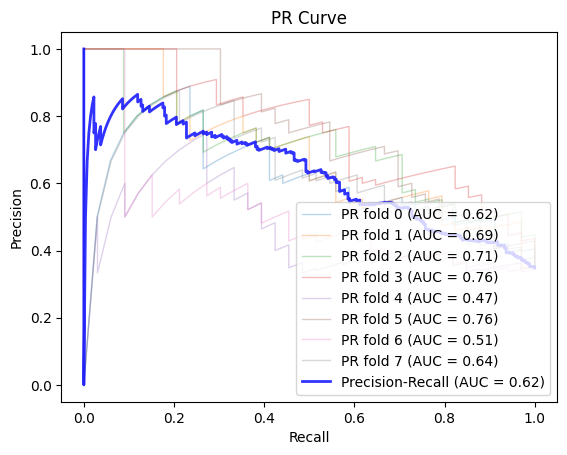

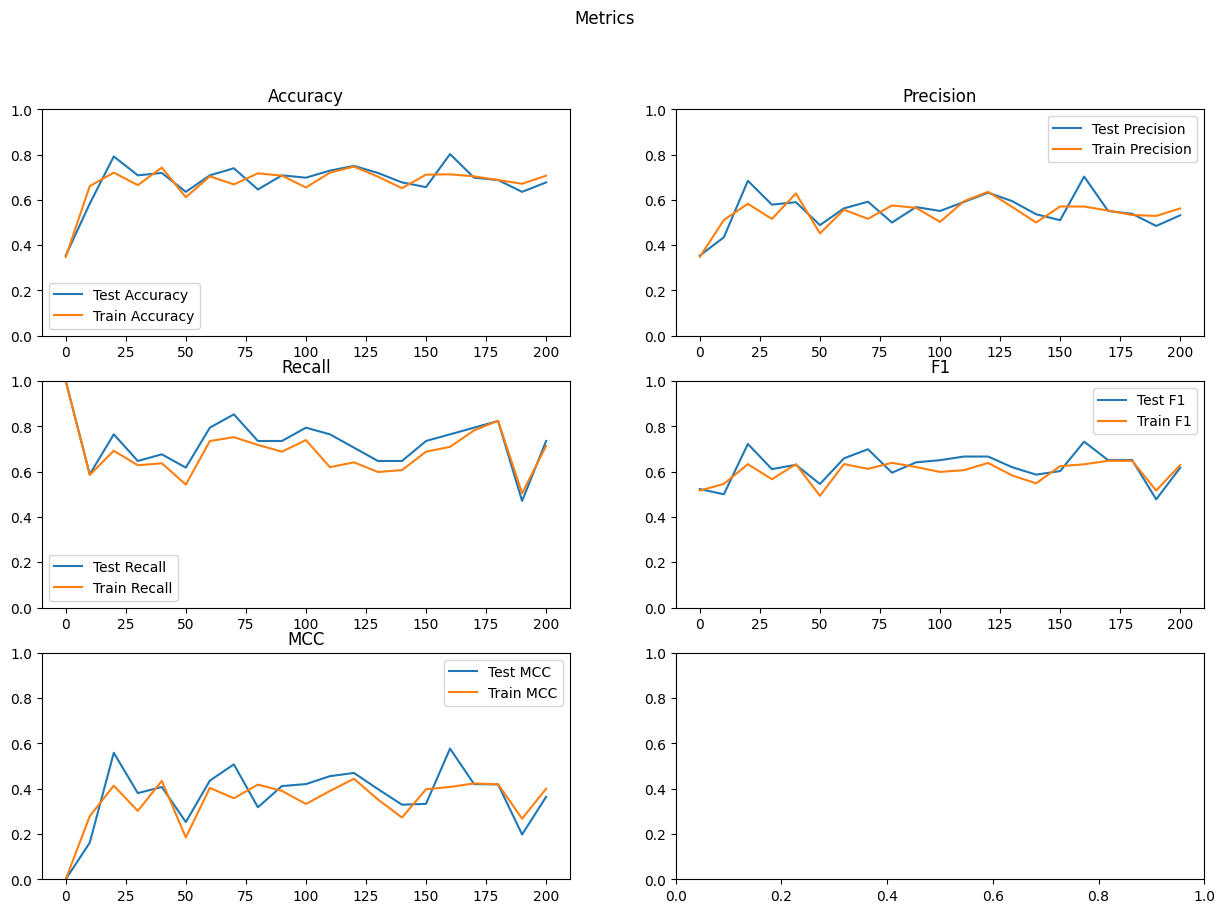

In [87]:
table_metrics(class_weights_fold_evals)
plot_pr_curve([test_dataset for train_dataset,
              test_dataset in folds], class_weights_fold_models)
plot_evals_subplot(
    class_weights_fold_evals[0][0], class_weights_fold_evals[0][1])
